In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray

import numpy as np

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral
import jax_cfd.spectral.subgrid_models as sgs
import jax_cfd.analysis.util as util

import dataclasses

import importlib
importlib.reload(sgs)

<module 'jax_cfd.spectral.subgrid_models' from '/storage/coda1/p-rg119/0/mreynoso6/dev_jax_cfd/jax_cfd/jax_cfd/spectral/subgrid_models.py'>

In [2]:
jax.config.update("jax_enable_x64", True)

#### Integrate NS

In [3]:
def initialize_ns(N,nu):
    max_velocity = 7
    grid = grids.Grid((N, N), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
    dt = cfd.equations.stable_time_step(max_velocity, .5, nu, grid)

    # setup step function using crank-nicolson runge-kutta order 4
    smooth = True # use anti-aliasing 
    ns = spectral.equations.NavierStokes2D(nu, grid, smooth=smooth, k_filter = 1/2)
    step_fn = spectral.time_stepping.crank_nicolson_rk4(ns, dt)
    # run the simulation up until time 25.0 but only save 10 frames for visualization
    final_time = 3.0#25.0
    outer_steps = 10
    inner_steps = (final_time // dt) // 10
    trajectory_fn = cfd.funcutils.trajectory(
        cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)
    # create an initial velocity field and compute the fft of the vorticity.
    # the spectral code assumes an fft'd vorticity for an initial state
    v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
    vorticity0 = cfd.finite_differences.curl_2d(v0).data
    vorticity_hat0 = jnp.fft.rfftn(vorticity0)
    _, trajectory = trajectory_fn(vorticity_hat0)
    return ns, trajectory, grid, dt * jnp.arange(outer_steps) * inner_steps

In [4]:
#%%time
# physical parameters
N = 2048
nu = 1e-3
ns, trajectory, grid, t = initialize_ns(N,nu)

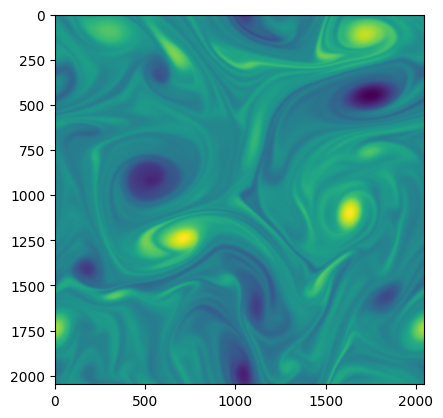

In [5]:
# transform the trajectory into real-space and wrap in xarray for plotting
"""
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': t,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);
        """
plt.imshow(jnp.fft.irfftn(trajectory[-1]))

In [6]:
importlib.reload(util)

<module 'jax_cfd.analysis.util' from '/storage/coda1/p-rg119/0/mreynoso6/dev_jax_cfd/jax_cfd/jax_cfd/analysis/util.py'>

In [7]:
flux_fn = util.make_flux_fn(ns)
flux_fn_jitted = jax.jit(flux_fn)
batched_flux_fn = jax.vmap(flux_fn_jitted, in_axes=(None, 0))
#batched_flux_fn = jax.vmap(batched_flux_fn, in_axes=(0,None))

In [8]:
k = jnp.logspace(jnp.log10(1),jnp.log10(N//2),num=64)
param = 2*jnp.pi/k
fluxes = []
for s in trajectory:
    result, _ = batched_flux_fn(s, param)
    fluxes.append(result)

fluxes = jnp.stack(fluxes, axis=-1)

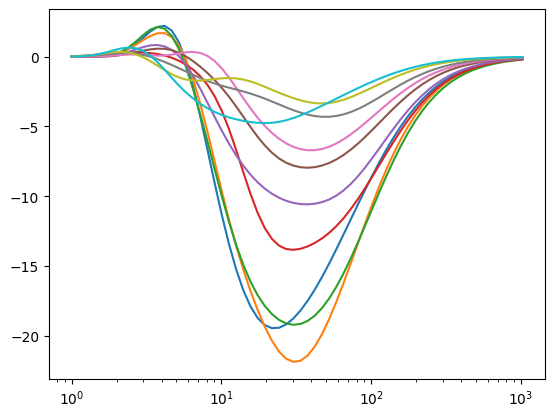

In [9]:
plt.semilogx(k,fluxes)
plt.show()  

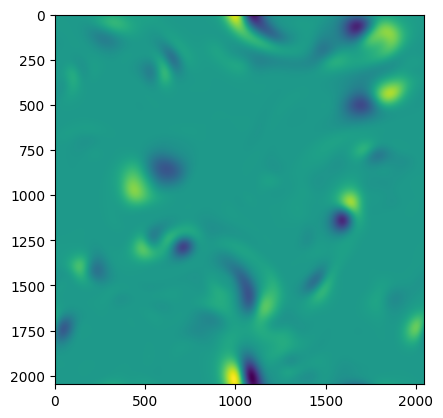

In [10]:
_, prof = flux_fn(trajectory[-1], 0.5)
plt.imshow(prof)

In [22]:
inner_steps = 5000
outer_steps = 10
nu = 1e-5
dt = 1e-4
Δ = 32.*jnp.pi/N
grid = grids.Grid((N, N), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
model = sgs.DNS_w_LES( viscosity=nu, grid=grid, smooth=True, k_filter = 1/2,
                                Delta=Δ, sgs_model_fn=sgs.NGM_4thOrder)
step_fn = spectral.time_stepping.crank_nicolson_rk4(model, dt)
trajectory_fn = cfd.funcutils.trajectory(cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)
w_end = trajectory[-1]
state = w_end, model.filter_fn( w_end )
state = dns_traj[-1], les_traj[-1]
_, traj = trajectory_fn( state )
dns_traj, les_traj = traj


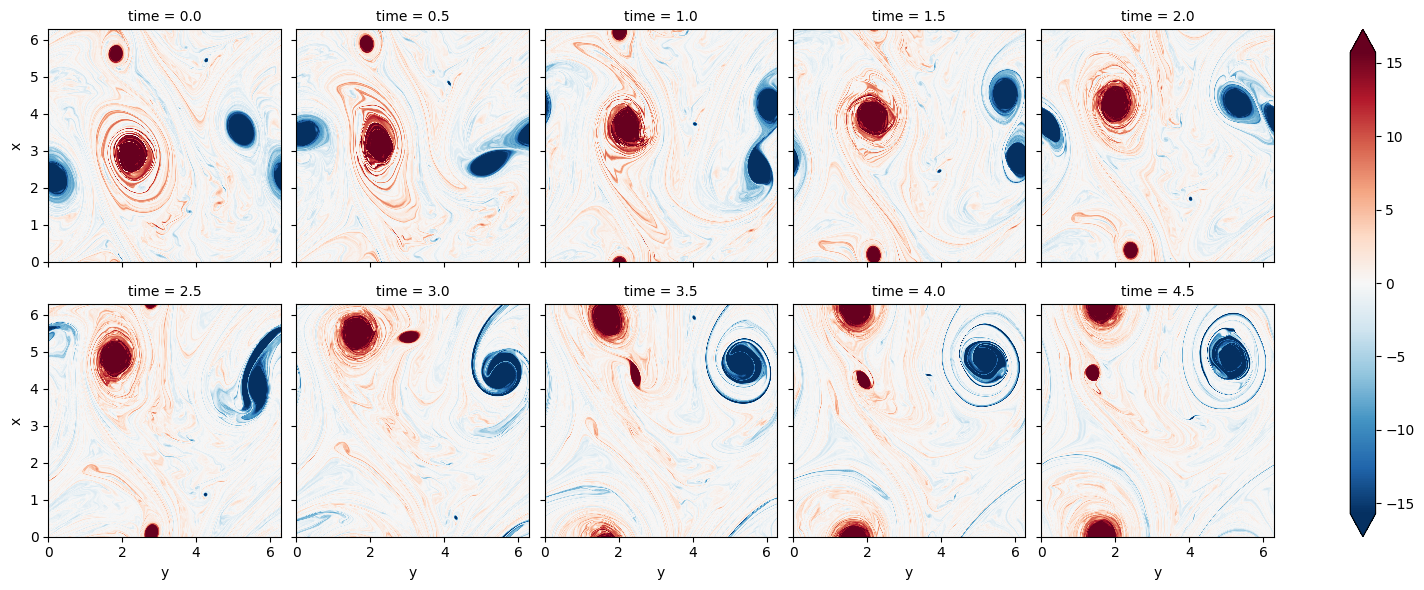

In [23]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(dns_traj, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, robust=True)

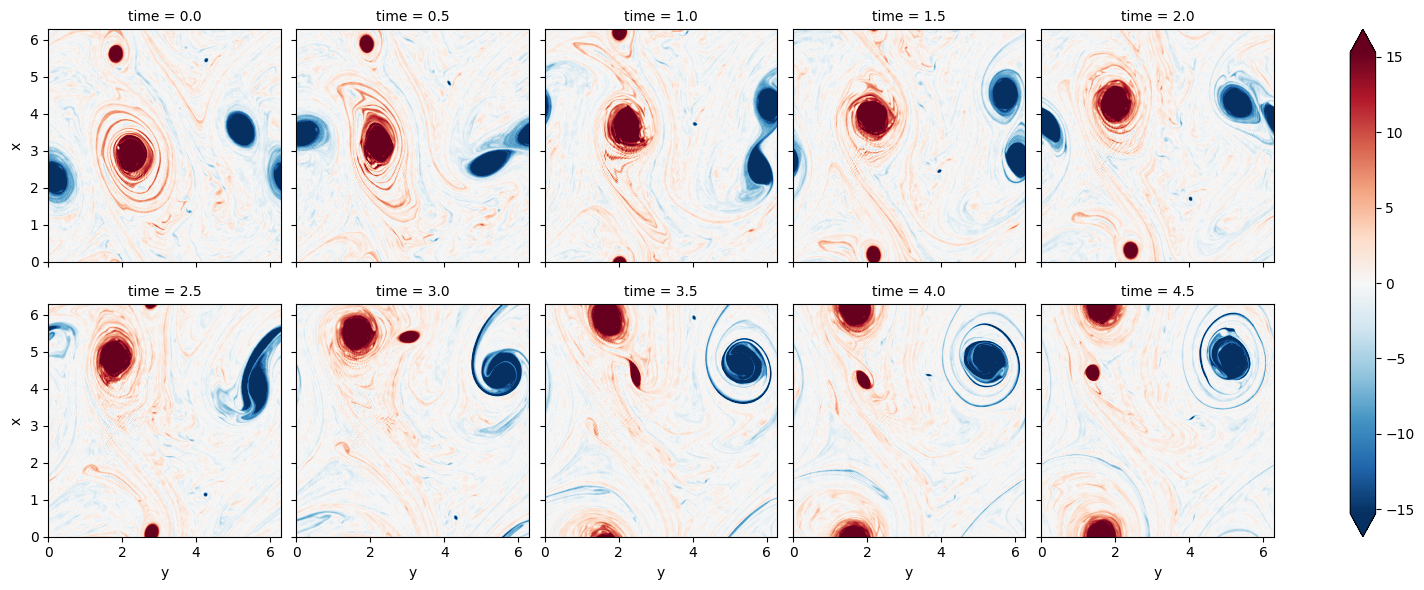

In [24]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(les_traj, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, robust=True)

In [25]:
kx, ky = grid.rfft_mesh()
h_spec_les = []
h_spec_dns = []

for s in les_traj:
    k, Espec = util.power_spectrum_2d(jnp.fft.irfftn(s),kx,ky)
    h_spec_les.append(Espec)
for s in dns_traj:
    k, Espec = util.power_spectrum_2d(jnp.fft.irfftn(s),kx,ky)
    h_spec_dns.append(Espec)


h_spec_les = jnp.stack(h_spec_les, axis=-1)
h_spec_dns = jnp.stack(h_spec_dns, axis=-1)

<function matplotlib.pyplot.show(close=None, block=None)>

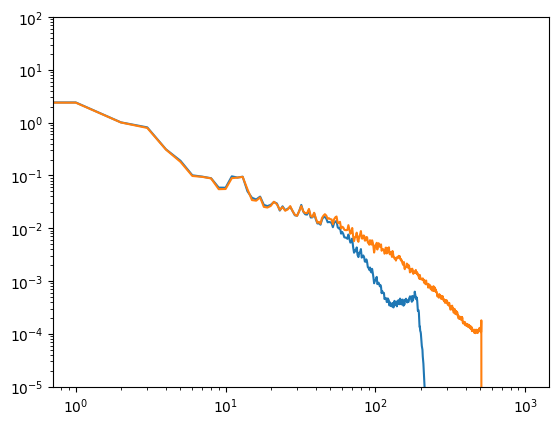

In [26]:
plt.loglog(h_spec_les[...,-2])
plt.loglog(h_spec_dns[...,-2])
plt.ylim([1e-5, 1e2])
plt.show

### Integrate NGM4

In [11]:
import jax_cfd.spectral.subgrid_models as sgs
importlib.reload(sgs)
seed = 0
inner_steps = 100
outer_steps = 10
nu = 1e-7
dt = 2e-4
N_les = 256
Δ = 12.*jnp.pi/N_les
grid = grids.Grid((N_les, N_les), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

model = sgs.NavierStokes2D_LES( viscosity=nu, grid=grid, smooth=True, k_filter = 1/2,
                                Delta=Δ, sgs_model_fn=sgs.NGM_4thOrder)

step_fn = spectral.time_stepping.crank_nicolson_rk4(model, dt)
trajectory_fn = cfd.funcutils.trajectory(cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)
w = jnp.fft.rfftn(spectral.utils.fourier_filter(jnp.fft.irfftn(trajectory[-1]), 2*jnp.pi/Δ))
#w = trajectory[-1]


In [12]:
def down_rez(x: jnp.ndarray, Nx: int, Ny: int) -> jnp.ndarray:
    """
    Downsample a 2D real input x from its current shape (Mx, My) to (Nx, Ny)
    by spectral truncation. Nx and Ny must be even and smaller than Mx, My.
    """
    Mx, My = x.shape
    assert Nx <= Mx and Ny <= My, "Output resolution must be <= input resolution"
    assert Mx % 2 == 0 and My % 2 == 0 and Nx % 2 == 0 and Ny % 2 == 0, "Only even dimensions supported"
 
    factor = (My / Ny) * (Mx / Nx)
 
    x_hat = jnp.fft.rfft2(x)  # shape: (Mx, My//2 + 1)
 
    # Select low-frequency components only
    x_hat_trunc = jnp.zeros((Nx, Ny // 2 + 1), dtype=x_hat.dtype)
 
    # Copy low frequencies
    x_hat_trunc = x_hat_trunc.at[:Nx // 2, :].set(x_hat[:Nx // 2, :Ny // 2 + 1])
    x_hat_trunc = x_hat_trunc.at[-Nx // 2:, :].set(x_hat[-Nx // 2:, :Ny // 2 + 1])
 
    x_downsampled = jnp.fft.irfft2(x_hat_trunc) / factor
 
    return x_downsampled

In [13]:
w_down = jnp.fft.rfftn(down_rez(jnp.fft.irfftn(w),N_les,N_les))
w_down.shape

(256, 129)

In [14]:
_, traj = trajectory_fn(w_down)

In [15]:
t_les =  dt * jnp.arange(outer_steps) * inner_steps

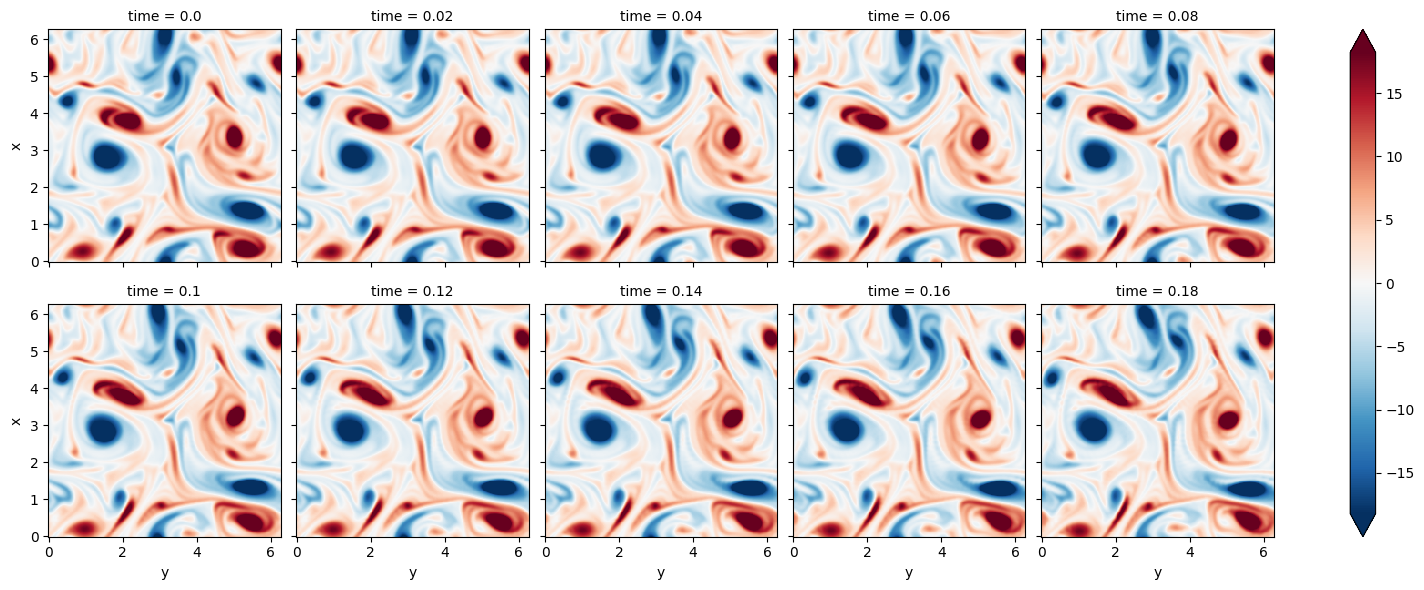

In [16]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time':t_les,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(traj, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, robust=True)

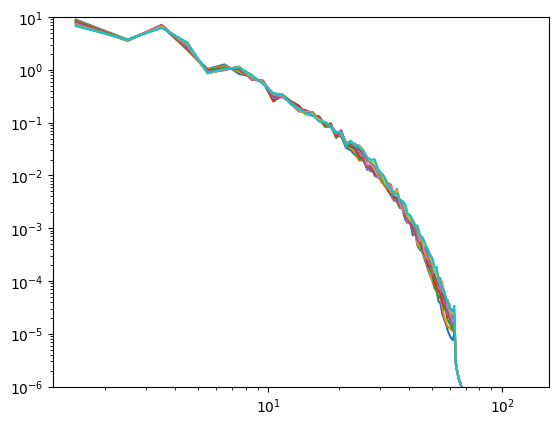

In [91]:
kx, ky = grid.rfft_mesh()
h_spec_les = []

for s in traj:
    k, Espec = util.power_spectrum_2d(jnp.fft.irfftn(s),kx,ky)
    h_spec_les.append(Espec)
h_spec_les = jnp.stack(h_spec_les, axis=-1)

plt.loglog(k, h_spec_les)
plt.ylim([1e-6,1e1])
plt.show()

In [92]:
importlib.reload(util)

<module 'jax_cfd.analysis.util' from '/storage/coda1/p-rg119/0/mreynoso6/dev_jax_cfd/jax_cfd/jax_cfd/analysis/util.py'>

In [93]:
flux_fn = util.make_flux_fn(model)
batched_flux_fn_param = jax.vmap(flux_fn, in_axes=(None, 0))
batched_flux_fn = jax.vmap(batched_flux_fn_param, in_axes=(0,None))

In [94]:
k = jnp.logspace(jnp.log10(1),jnp.log10(N_les),num=64)
param = 2*jnp.pi/k
result, _ = batched_flux_fn(traj, param)

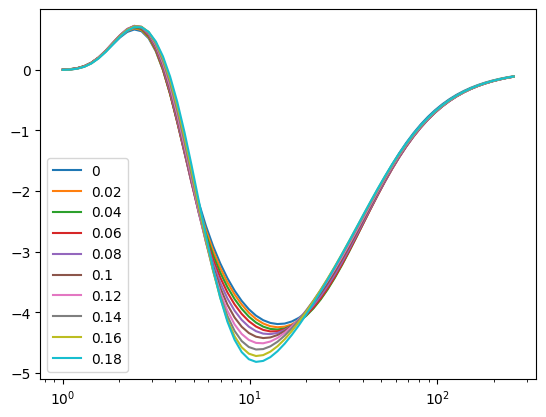

In [95]:
plt.semilogx(k,jnp.swapaxes(result, 0, 1))
plt.legend([f"{val:.2g}" for val in t_les] )
plt.show()

Text(0.5, 1.0, 'LES (NGM4)')

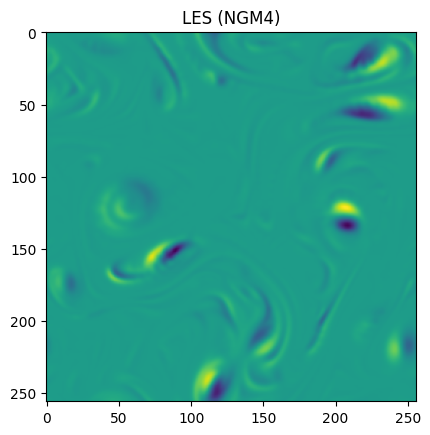

In [106]:
#_, prof = flux_fn(step_fn(w_down), 0.1)
_, prof = flux_fn(traj[-1], 0.1)
#_, prof = flux_fn(w_down, 0.1)
plt.imshow(prof)
plt.title('LES (NGM4)')

In [97]:
trajectory_fn_ns = cfd.funcutils.trajectory(
        cfd.funcutils.repeated(spectral.time_stepping.crank_nicolson_rk4(ns, dt), inner_steps), outer_steps)
_, traj_les = trajectory_fn_ns(trajectory[-1])


In [98]:
flux_dns_les = util.make_flux_dns_to_les_fn(ns,Δ)
batched_flux_les_fn = jax.vmap(flux_dns_les, in_axes=(None, 0))

In [99]:
k = jnp.logspace(jnp.log10(1),jnp.log10(N//2),num=64)
param = 2*jnp.pi/k
fluxes_dns_les = []
for s in traj_les:
    res, _ = batched_flux_les_fn(s, param)
    fluxes_dns_les.append(res)

fluxes_dns_les = jnp.stack(fluxes_dns_les, axis=-1)

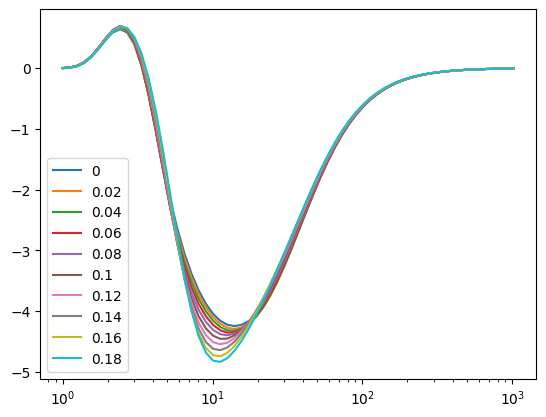

In [100]:
plt.semilogx(k,fluxes_dns_les)
plt.legend([f"{val:.2g}" for val in t_les] )
plt.show()

Text(0.5, 1.0, 'DNS')

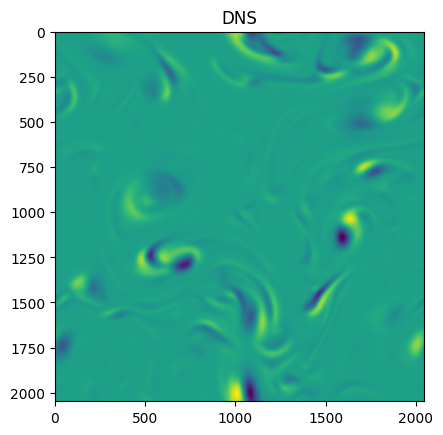

In [101]:
_, prof = flux_dns_les(trajectory[-1], 0.1)
plt.imshow(prof)
plt.title("DNS")

Text(0.5, 1.0, 'DNS')

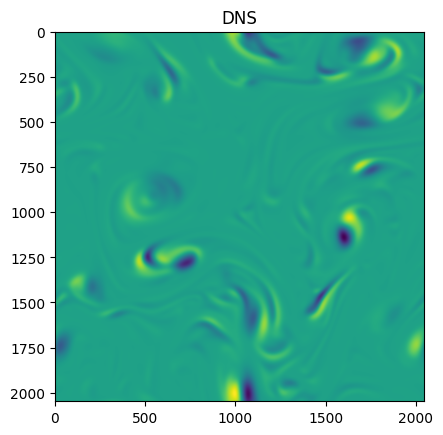

In [102]:
_, prof = flux_dns_les(traj_les[0], 0.1)
plt.imshow(prof)
plt.title("DNS")

In [103]:
last_w = jnp.squeeze(trajectory[-1])

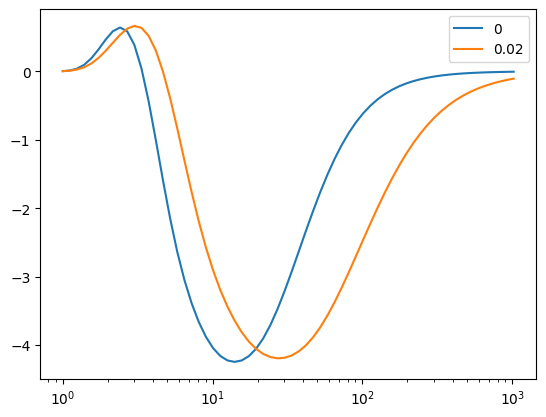

In [104]:
plt.semilogx(k,fluxes_dns_les[...,0])
plt.semilogx(k,result[0,:])
plt.legend([f"{val:.2g}" for val in t_les] )
plt.show()

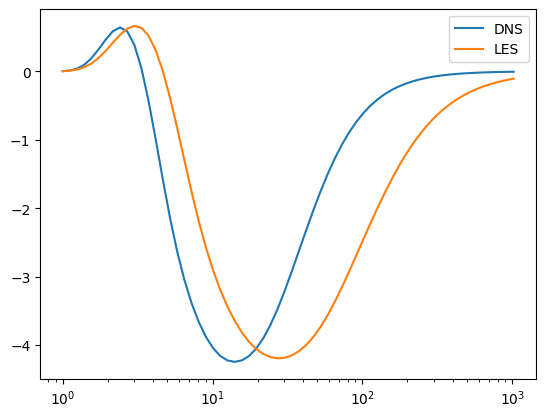

In [105]:
plt.semilogx(k,fluxes_dns_les[...,0])
plt.semilogx(k,result[0,:])
plt.legend(['DNS','LES'] )
plt.show()

### Compute spectrum behavior

In [26]:
kx, ky = grid.rfft_mesh()
Espec_all = []

for s in traj:
    k, Espec = util.power_spectrum_2d(jnp.fft.irfftn(s),kx,ky)
    Espec_all.append(Espec)

Espec_concat = jnp.stack(Espec_all, axis=-1)

<function matplotlib.pyplot.show(close=None, block=None)>

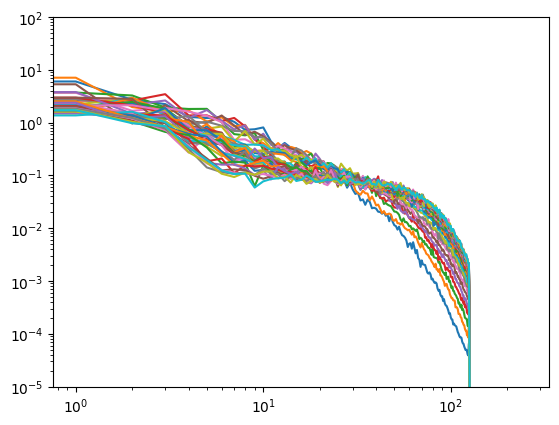

In [27]:
plt.loglog(Espec_concat)
plt.ylim([1e-5, 1e2])
plt.show

In [ ]:
def product_spectrum( u_hat, v_hat, kx, ky ):
    """
    Compute the isotropic power spectrum of a 2D real-valued field using JAX.
    Args:
        field (jnp.ndarray): 2D real-valued array.
        box_size (float): Physical size of the domain (assumed square).
        bins (int): Number of bins for the isotropic spectrum.

    Returns:
        k_bin_centers (jnp.ndarray): 1D array of wavenumber magnitudes.
        Pk (jnp.ndarray): 1D power spectrum.
    """
    

    # Compute FFT and power
    Nx, Ny = u_hat.shape
    Ny = 2*(Ny+1)
    power = (u_hat*jnp.conj(v_hat)).real

    # Build wavenumber grids
    k_mag = jnp.sqrt(((2*jnp.pi)*kx)**2 + ((2*jnp.pi)*ky)**2)

    # Flatten and bin by magnitude
    k_flat = k_mag.flatten()
    power_flat = power.flatten()

    bins = Nx//2
    k_bins = np.linspace(1, Nx//2, Nx//2)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    bin_idx = jnp.digitize(k_flat, k_bins) - 1  # bin indices
    # Remove out-of-range indices
    valid = (bin_idx >= 0) & (bin_idx < bins)
    bin_idx = bin_idx[valid]
    power_flat = power_flat[valid]

    # Compute sum and counts per bin
    Pk_sum = jnp.bincount(bin_idx, weights=power_flat, length=bins)
    #counts = jnp.bincount(bin_idx, length=bins)
    
    return k_bin_centers, Pk_sum[1:]/(Nx*Ny)**2

In [57]:
rs_all = []
for s in traj:
    rhs = model.explicit_terms(s) + model.implicit_terms(s)
    #rhs = jnp.fft.irfftn(rhs)
    #vort = jnp.fft.irfftn(s)
    k, rhs_spec = product_spectrum( s, rhs, kx, ky )
    rs_all.append(rhs_spec)
rs_all = jnp.stack(rs_all, axis=-1)

<function matplotlib.pyplot.show(close=None, block=None)>

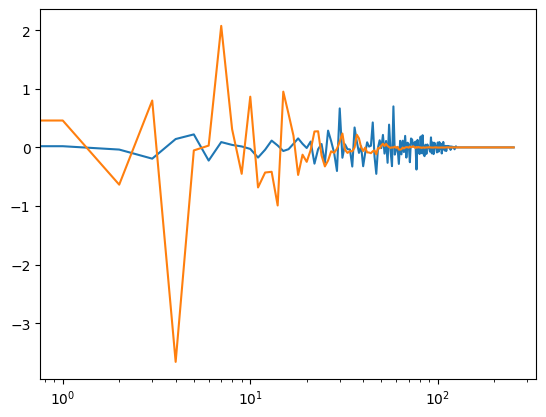

In [67]:
plt.semilogx(rs_all[:,-1])
plt.semilogx(dns_all[:,-1])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

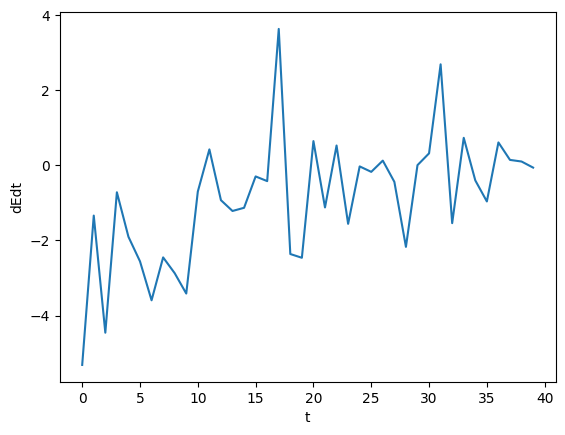

In [31]:
plt.plot(np.sum(rs_all,axis=0))
plt.ylabel('dEdt')
plt.xlabel('t')
plt.show

In [60]:
dns_all = []
for s in trajectory:
    rhs = ns.explicit_terms(s) + ns.implicit_terms(s)
    #rhs = jnp.fft.irfftn(rhs)
    #vort = jnp.fft.irfftn(s)
    k, rhs_spec = product_spectrum( s,rhs, kx, ky )
    dns_all.append(rhs_spec)
dns_all = jnp.stack(dns_all, axis=-1)

<function matplotlib.pyplot.show(close=None, block=None)>

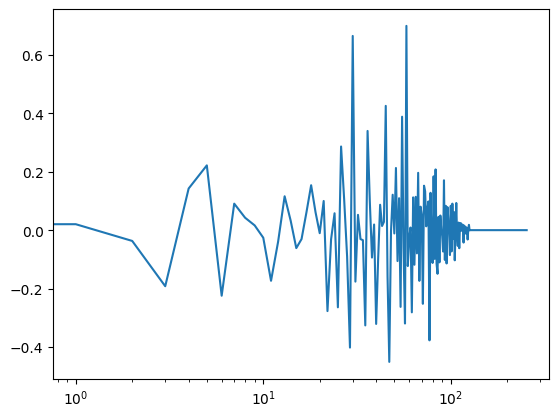

In [54]:
plt.semilogx(dns_all[-1,:])
plt.show

In [18]:
np.sum(rs_all[0])

Array(8.97355546, dtype=float64)

<function matplotlib.pyplot.show(close=None, block=None)>

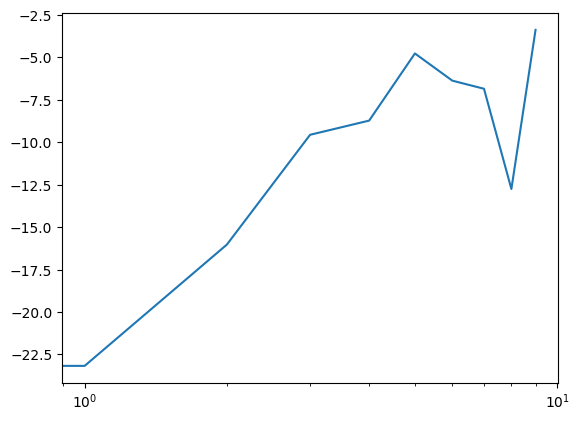

In [19]:
plt.semilogx(np.sum(rs_all,axis=0))
plt.show